This Notebook will do the following:
- Find correlation of various economic vairble

In [1]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import scipy.stats
import seaborn as sns
import yfinance as yf

Adjust the time span as needed, and if necessary, select the closest quarter to reflect the most updated information.

In [2]:
time_span = 2

time_frame = '{}YR QTR'.format(time_span) 
closest_qrt = datetime.strptime("2024-01-01", "%Y-%m-%d")
start_date =  "{}-01-01".format(int(str(closest_qrt)[0:4]) - time_span)

# (Ticker, Rename, Data has Pct%? )
econ_variables =[
    ['DPCERL1Q225SBEA', 'R PCE', True],
    ['GPDIC1', 'R Inv.', False],
    ['GCEC1', 'R Gov Exp.', False],
    ['NETEXC', 'R NX', False],
    ['GDPC1', 'R GDP', False], 
    ['MSPUS', 'MSPUS', False], 
    ['DRCCLACBS', 'CCl Rate, All Banks', True],
    ['GFDEGDQ188S', 'FD/GDP', True],
    ['GFDEBTN', 'FD', False],
    ['M2V', 'M2V', False],
    ['LES1252881600Q', 'Mean Weekly Wage', False],
    ['CCLACBQ158SBOG', 'Cons. Debt', True],
    ['IPB50001SQ', 'Industrial Production', False],
    ['DPSACBQ158SBOG', 'Bank Deposits', True],
    ['A939RX0Q048SBEA', 'R GDP/L', False],
    ['BPCCRO1Q156NBEA', 'PCE Wo F&E', True],
    ['A091RC1Q027SBEA', 'Gov Exp:i', False],
    ['DRSFRMACBS', 'Delg. Mort', True],
    ['GDPDEF', 'GDPDEF', False],
    ['MMMFFAQ027S', '$ M', False],
    ['DPIC96', 'Disp. $', False],
    ['GDPPOT', 'R Pot. GDP', False],
]


In [3]:
def get_stock_data_w_returns(symbol, freq='3mo'):
    stock_data = yf.download(symbol, start=start_date, end=closest_qrt, interval=freq, rounding=True)
    stock_data['Returns (%)'] = (stock_data['Adj Close'].pct_change() * 100).round(2)
    stock_data.reset_index(inplace=True) 
    stock_data.dropna(inplace=True)
    return stock_data

def get_fred_data(symbol, rename=None, pct=True):
    fred_data = pdr.DataReader(symbol, 'fred', start=start_date, end=closest_qrt)
    fred_data.reset_index(inplace=True)
    if rename:
        fred_data.rename(columns={symbol: rename}, inplace=True)
    fred_data.dropna(inplace=True)
    if pct == False:
        fred_data['Change (%)'] = ((fred_data[rename] - fred_data[rename].shift(1)) / abs(fred_data[rename].shift(1)) * 100).round(2)
        fred_data.rename(columns={'Change (%)': '{} Change (%)'.format(rename)}, inplace=True)
    else:
        fred_data.rename(columns={rename: '{} Change (%)'.format(rename)}, inplace=True)
    fred_data.dropna(inplace=True)
    fred_data = fred_data.apply(lambda col: col.round(2) if col.dtype == 'float64' else col)
    return fred_data

def get_econ_df(variable_list, only_pct=False):
    df_list = []
    for sublist in variable_list:
        symbol = sublist[0]
        rename = sublist[1]
        is_pct = sublist[2]
        df = get_fred_data(symbol, rename=rename, pct=is_pct)
        df_list.append(df)
    econ_df = pd.concat(df_list, axis=1)
    
    dates = list(econ_df.loc[1, 'DATE'])
    first_date = dates[0]
    all_match = True
           
    for date in dates:
        first_date = dates[0]
    if dates[1] != first_date:
        all_match = False
    if all_match == True:
        econ_df = econ_df.loc[:, ~econ_df.columns.duplicated()]
        econ_df.dropna(inplace=True)
        if only_pct == True:
            change_df = econ_df.filter(regex='(%|DATE)')
            return change_df
        else:
            return econ_df
    else:
        print('ERROR: Data Frequency Does Not Match')

In [4]:
psav = get_fred_data('PSAVE', 'PSAVE', False)

In [5]:
spy_df = get_stock_data_w_returns('spy', freq='3mo')
econ_df = get_econ_df(econ_variables, only_pct=True)
econ_df.head()

[*********************100%%**********************]  1 of 1 completed


,DATE,R PCE Change (%),R Inv. Change (%),R Gov Exp. Change (%),R NX Change (%),R GDP Change (%),MSPUS Change (%),"CCl Rate, All Banks Change (%)",FD/GDP Change (%),FD Change (%),...,Industrial Production Change (%),Bank Deposits Change (%),R GDP/L Change (%),PCE Wo F&E Change (%),Gov Exp:i Change (%),Delg. Mort Change (%),GDPDEF Change (%),$ M Change (%),Disp. $ Change (%),R Pot. GDP Change (%)
1,2022-04-01,2.0,-2.77,-0.48,2.18,-0.14,5.85,1.84,119.67,0.55,...,0.97,1.2,-0.24,5.2,7.59,1.96,2.20,-1.14,-0.36,0.52
2,2022-07-01,1.6,-1.97,0.71,12.09,0.66,0.07,2.06,118.98,1.18,...,0.34,-2.1,0.53,5.2,10.23,1.84,1.10,1.03,0.89,0.52
3,2022-10-01,1.2,0.84,1.30,1.60,0.64,1.05,2.26,118.98,1.59,...,-0.44,-5.9,0.50,5.1,10.06,1.79,0.95,2.73,0.54,0.51
4,2023-01-01,3.8,-2.34,1.18,3.16,0.56,-3.07,2.45,117.32,0.12,...,-0.00,-4.9,0.45,4.8,5.33,1.74,0.97,8.99,2.61,0.51
5,2023-04-01,0.8,1.27,0.83,0.74,0.51,-2.45,2.76,119.47,2.78,...,0.07,-7.2,0.39,4.6,4.10,1.72,0.42,3.95,0.81,0.50


Turn into a funtion to check if correct dates, and if not then notify 

In [6]:
# # KEEP KEEP KEEP KEEP
# Turn into a funtion

date_test = pd.concat([spy_df['Date'], econ_df['DATE']], axis=1)
date_test.rename(columns={'Date': 'spy_dates', 'DATE': 'econ_dates'}, inplace=True)
date_test['correct_dates?'] = (date_test['spy_dates'] == date_test['econ_dates'])

print('Data should start at {}'.format(start_date))

if not date_test.empty:
    print('Dates Match')
else:
    print('Data comparison could not be completed or is empty.')

Data should start at 2022-01-01
Dates Match


In [7]:
corr_data = []

for col in econ_df.columns:
    if col not in ('DATE'):
        corr = econ_df[col].corr(spy_df['Returns (%)'])
        corr_data.append({'Name': col, 'Correlation': round(corr, 2)})

corr_df = pd.DataFrame(corr_data)
corr_df = corr_df.sort_values(by='Correlation', ascending=False)
corr_df

,Name,Correlation
2,R Gov Exp. Change (%),0.76
19,$ M Change (%),0.68
10,Mean Weekly Wage Change (%),0.66
6,"CCl Rate, All Banks Change (%)",0.65
4,R GDP Change (%),0.48
14,R GDP/L Change (%),0.48
20,Disp. $ Change (%),0.47
1,R Inv. Change (%),0.43
8,FD Change (%),0.40
9,M2V Change (%),0.28


<Figure size 3200x2400 with 0 Axes>

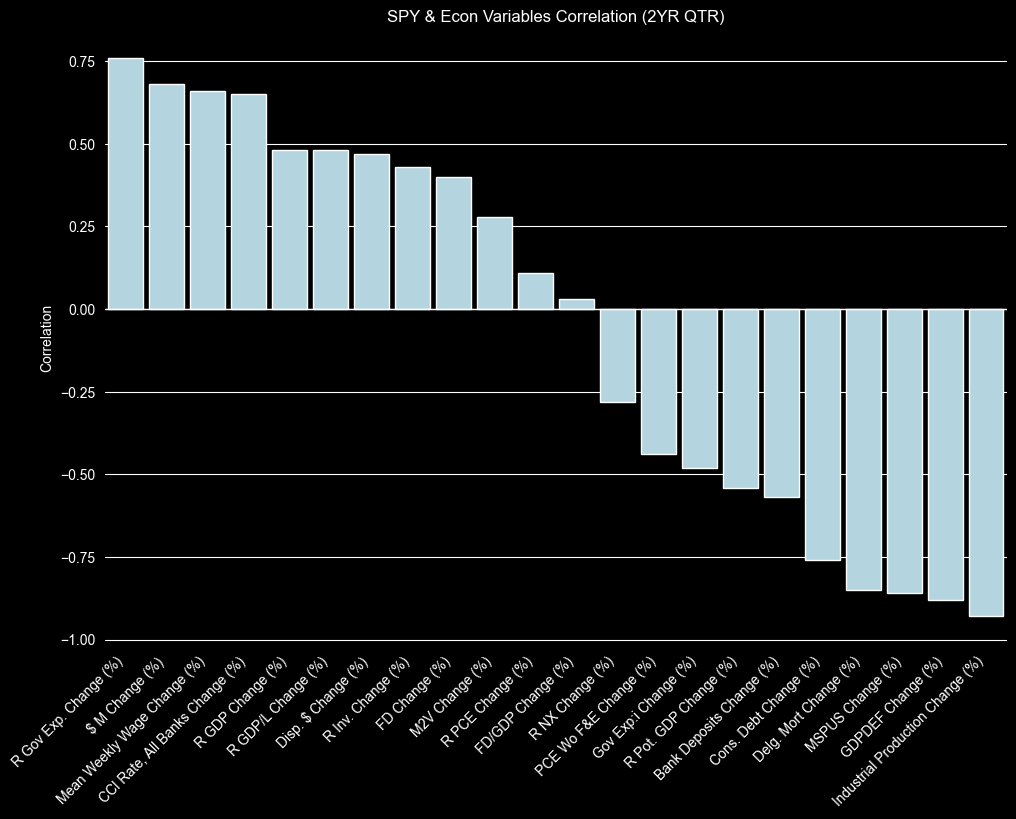

In [8]:
# sns.set_style("whitegrid")

sns.set_style('darkgrid')
plt.style.use('dark_background')
plt.figure(dpi=500)
f, ax = plt.subplots(figsize=(10, 8))

# Create a bar plot
sns.set_color_codes('pastel')
ax = sns.barplot(x='Name', y='Correlation', data=corr_df, label=None, color='lightblue', width=0.85)
plt.grid(axis='y', color='white')
plt.axhline(0, color='white', linewidth=1)

# Rotate the x-axis labels to prevent overlapping
plt.xticks(rotation=45, ha='right')
plt.xlabel(None)
plt.ylabel('Correlation')
plt.title(('SPY & Econ Variables Correlation ({})').format(time_frame))


sns.despine(left=True, bottom=True)
plt.tight_layout(pad=0.02)